## Arizona State COVID Vaccination
Now let's apply the same techniques we learned over the last few weeks to a new data set.  Today's data differs from last week's in several ways.    First, we're interested in the relationship between SVI and Vaccination rates, rather than infection rates.  This is important, because this directly relates to policy decisions.  If we can get an understanding of who is not getting vaccinated, then we can better allocate resources to address those needs. Secondly, this is statewise data, rather than city data, so we might expect the results to vary significantly across regions, say from the big cities of Tuscon and Phoenix, in comparison to the much more sparsely populated Native American reservations.  Finally, the data is organized by zip codes instead of census tracts.  On average, this is a slightly coarser description.  But it's not just coarser, but much more variable -- some of the zip codes have fewer than 100 people, and some nearly 100,000.





**import packages**


In [78]:

# Add this code to the very top of your COLAB 




# BEFORE RUNNING THIS CODE

# Do this: Right click the 'lessons' folder in your 'shared with me', 

# and press 'add shortcut to drive'




directory = 'week4'




# Mount all files in the google drive into the colab on the path '/drive'

# https://stackoverflow.com/questions/54351852/accessing-shared-with-me-with-colab

from google.colab import drive

drive.mount('/drive', force_remount=True)




# Tell python to import files in drive directory

# https://stackoverflow.com/questions/4383571/importing-files-from-different-folder

import sys

sys.path.append('/drive/MyDrive/' + directory)




# Set working directory to drive directory

# https://stackoverflow.com/questions/1810743/how-to-set-the-current-working-directory/1810760

import os

os.chdir('/drive/MyDrive/' + directory)

Mounted at /drive


In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
# Step 1: Load the data

In [80]:
#ipywidgets helps you explore various columns easier
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

#These makes sure all clumns are displayed
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [81]:
#Some packages that we may not need but just in case
import json
import requests
import pickle
import copy
import warnings
import scipy.stats as stats

In [82]:
#Preprocessing and tensorflow (for neural networks)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
# scikit-learn bootstrap
from sklearn.utils import resample

**Load the data**

In [83]:
#load the dataset

AZ_VACC_SVI_df = pd.read_pickle('AZ_vacc_SVI_df.pkl')
z = AZ_VACC_SVI_df;

z.index.name ='ZIP'
z.head()


,SVI1,SVI2,SVI3,SVI4,SVI,Educ_<HS_prop,Educ_HS_prop,Educ_AA_prop,Educ_BA_prop,Educ_Msters_prop,Educ_Prof_prop,Educ_Doctorate_prop,Husband_Wife_Family_prop,Single_Parent_Family_prop,Single_Family_prop,Single_w_roommate_Family_prop,Whites_count_prop,AA_count_prop,AI_Alaskan_count_prop,Asian_count_prop,Hawaiian_PI_count_prop,Others_count_prop,Multi_count_prop,population,population_density,median_home_value,median_household_income,COVID_VACC_RATE
ZIP,,,,,,,,,,,,,,,,,,,,,,,,,,,,
85003,0.656050,0.229933,0.602683,0.751400,0.588833,0.234431,0.383234,0.051647,0.191916,0.067515,0.049850,0.021407,0.214872,0.150256,0.525641,0.109231,0.633045,0.109297,0.026897,0.012168,0.002348,0.181023,0.035223,9369.0,5061.0,260500.0,36390.0,57.54
85004,0.656050,0.229933,0.602683,0.751400,0.588833,0.160126,0.419152,0.076923,0.203768,0.078807,0.046154,0.015071,0.162642,0.113440,0.588610,0.135308,0.657603,0.087009,0.040483,0.026586,0.001208,0.149043,0.038066,4965.0,2434.0,205200.0,26008.0,85.66
85006,0.882930,0.427860,0.868670,0.884960,0.870520,0.383176,0.429661,0.043894,0.095704,0.039001,0.004893,0.003670,0.309048,0.275540,0.302627,0.112785,0.522997,0.050695,0.029174,0.010333,0.001360,0.347098,0.038342,25742.0,6595.0,112700.0,22957.0,50.68
85007,0.804087,0.451450,0.781050,0.830737,0.789850,0.299138,0.419532,0.044238,0.144137,0.058573,0.023631,0.010751,0.294118,0.250883,0.337352,0.117647,0.525214,0.133903,0.031339,0.022293,0.001211,0.247792,0.038248,14040.0,3110.0,194200.0,28125.0,61.29
85008,0.776771,0.357906,0.857200,0.805824,0.785735,0.336838,0.432526,0.053182,0.124080,0.040095,0.007460,0.005820,0.311649,0.253253,0.316985,0.118113,0.539211,0.095467,0.040057,0.015923,0.002511,0.265545,0.041286,56145.0,5364.0,109100.0,32109.0,50.89


**For starters, generate scatter plots for Vaccination Rates.  For starters, take a look at SVI index.  Then we can investigate individual RPL Themes.**


First make sure to drop all the missing numbers and NaNs.  Then should also check for other weird numbers.  What data looks bad?  Why is it bad, and what should we do about it?  If you remove any data, keep track of how much you've thrown away.

In [84]:
temp1 = z.dropna()
temp1.head()

[z.shape,temp1.shape]

[(368, 28), (341, 28)]

In [85]:
temp1.describe()

,SVI1,SVI2,SVI3,SVI4,SVI,Educ_<HS_prop,Educ_HS_prop,Educ_AA_prop,Educ_BA_prop,Educ_Msters_prop,Educ_Prof_prop,Educ_Doctorate_prop,Husband_Wife_Family_prop,Single_Parent_Family_prop,Single_Family_prop,Single_w_roommate_Family_prop,Whites_count_prop,AA_count_prop,AI_Alaskan_count_prop,Asian_count_prop,Hawaiian_PI_count_prop,Others_count_prop,Multi_count_prop,population,population_density,median_home_value,median_household_income,COVID_VACC_RATE
count,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,341.000000,3.410000e+02,341.000000,341.000000
mean,0.558897,0.540614,0.549413,0.511643,0.554547,0.159207,0.527548,0.080159,0.147035,0.062061,0.013904,0.010085,0.502164,0.168889,0.261546,0.067401,0.759759,0.025744,0.063936,0.018434,0.001556,0.099322,0.031249,18376.401760,1325.419355,1.703264e+05,48693.991202,54.268886
std,0.239670,0.193975,0.206190,0.205157,0.236732,0.122612,0.104872,0.032075,0.089347,0.047490,0.018643,0.012379,0.118052,0.082328,0.088914,0.031661,0.196392,0.030097,0.179528,0.019990,0.003135,0.098984,0.012534,17176.012862,1943.405178,1.063348e+05,19467.884402,34.943748
min,0.012300,0.046100,0.060700,0.011925,0.015350,0.000000,0.228031,0.000000,0.000000,0.000000,0.000000,0.000000,0.148148,0.013405,0.056917,0.009772,0.012236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,9.999000e+03,11799.000000,0.000000
25%,0.389060,0.395600,0.394040,0.346800,0.379650,0.065317,0.460080,0.061943,0.079398,0.027536,0.001740,0.000435,0.428840,0.113067,0.202183,0.049383,0.677527,0.004815,0.008576,0.004464,0.000445,0.026907,0.022932,2627.000000,11.000000,1.063000e+05,34707.000000,40.960000
50%,0.584000,0.551310,0.537100,0.530543,0.579100,0.127533,0.533822,0.081399,0.128931,0.049375,0.008148,0.006023,0.510285,0.154183,0.256014,0.060367,0.818718,0.013141,0.014457,0.009689,0.001138,0.063126,0.030553,14823.000000,151.000000,1.475000e+05,44764.000000,53.000000
75%,0.750160,0.686650,0.716433,0.668300,0.746067,0.218147,0.596804,0.098063,0.206480,0.090362,0.018420,0.014997,0.585136,0.205128,0.316985,0.077253,0.894752,0.037461,0.029174,0.027317,0.001916,0.144737,0.038907,32666.000000,2124.000000,2.070000e+05,57109.000000,63.520000
max,0.980850,0.966300,0.976550,0.975800,0.984750,0.636364,0.778816,0.202186,0.401432,0.381703,0.144066,0.081317,0.756541,0.541068,0.588610,0.291061,0.994350,0.206255,0.973304,0.123632,0.053228,0.434107,0.121951,74904.000000,8700.000000,1.000001e+06,125884.000000,547.250000


In [86]:
temp2 = temp1[temp1['COVID_VACC_RATE']<100]
temp2.describe()

,SVI1,SVI2,SVI3,SVI4,SVI,Educ_<HS_prop,Educ_HS_prop,Educ_AA_prop,Educ_BA_prop,Educ_Msters_prop,Educ_Prof_prop,Educ_Doctorate_prop,Husband_Wife_Family_prop,Single_Parent_Family_prop,Single_Family_prop,Single_w_roommate_Family_prop,Whites_count_prop,AA_count_prop,AI_Alaskan_count_prop,Asian_count_prop,Hawaiian_PI_count_prop,Others_count_prop,Multi_count_prop,population,population_density,median_home_value,median_household_income,COVID_VACC_RATE
count,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,331.000000,3.310000e+02,331.000000,331.000000
mean,0.558157,0.539407,0.548793,0.510123,0.553199,0.157136,0.529123,0.081273,0.146699,0.062186,0.013689,0.009894,0.501021,0.168857,0.261893,0.068230,0.759475,0.026336,0.063175,0.018843,0.001564,0.099083,0.031523,18754.416918,1360.368580,1.685290e+05,48764.196375,50.842236
std,0.238310,0.192852,0.204030,0.204007,0.234891,0.120905,0.104822,0.031651,0.088628,0.047001,0.018207,0.011927,0.117643,0.080606,0.089073,0.031645,0.194448,0.030330,0.177409,0.020130,0.003149,0.097950,0.012504,17233.813639,1961.528133,1.026822e+05,19355.925305,18.453895
min,0.012300,0.046100,0.060700,0.011925,0.015350,0.000000,0.228031,0.000000,0.000000,0.000000,0.000000,0.000000,0.148148,0.030421,0.056917,0.009772,0.012236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,0.000000,9.999000e+03,11799.000000,0.000000
25%,0.388790,0.391825,0.397143,0.347943,0.378625,0.065961,0.460760,0.063204,0.079472,0.028339,0.002012,0.000498,0.428905,0.113317,0.201424,0.050177,0.679729,0.005232,0.008876,0.004519,0.000459,0.027093,0.023171,2806.000000,11.000000,1.060500e+05,35497.500000,40.675000
50%,0.584000,0.551310,0.534450,0.520725,0.576150,0.125475,0.534766,0.081765,0.128931,0.050000,0.008252,0.006023,0.510000,0.154206,0.256186,0.061297,0.818605,0.014152,0.014748,0.010275,0.001164,0.063130,0.030749,15083.000000,161.000000,1.479000e+05,44989.000000,52.190000
75%,0.749659,0.682961,0.711371,0.668204,0.742979,0.213028,0.603186,0.099716,0.206361,0.089676,0.018407,0.014980,0.583824,0.203757,0.318117,0.077891,0.894295,0.038158,0.029198,0.027757,0.001925,0.143610,0.038982,32925.500000,2339.500000,2.026000e+05,57436.000000,62.710000
max,0.980850,0.966300,0.976550,0.975800,0.984750,0.636364,0.778816,0.202186,0.401432,0.381703,0.144066,0.081317,0.756541,0.541068,0.588610,0.291061,0.994350,0.206255,0.973304,0.123632,0.053228,0.434107,0.121951,74904.000000,8700.000000,1.000001e+06,125884.000000,92.250000


Create a scatter plot for vaccination rate as a function of SVI, and report the correlation.  Do the same for each of the RPLs (SVI1, SVI1, SVI3, SVI4)


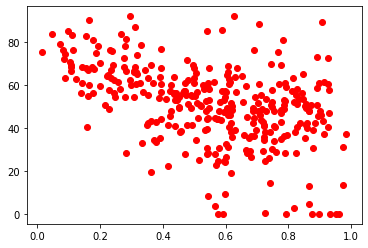

In [87]:
# scatter plot
x = temp2['SVI']
y = temp2['COVID_VACC_RATE']

plt.plot(x, y, 'o', color='red');

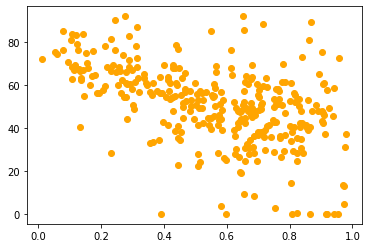

In [88]:
# scatter plot
x = temp2['SVI1']
y = temp2['COVID_VACC_RATE']

plt.plot(x, y, 'o', color='orange');

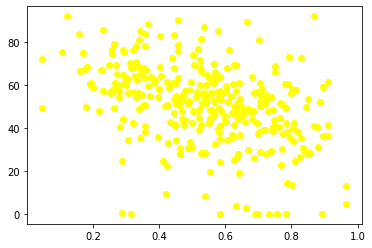

In [89]:
# scatter plot
x = temp2['SVI2']
y = temp2['COVID_VACC_RATE']

plt.plot(x, y, 'o', color='yellow');

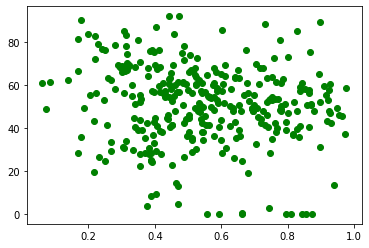

In [90]:
# scatter plot
x = temp2['SVI3']
y = temp2['COVID_VACC_RATE']

plt.plot(x, y, 'o', color='green');

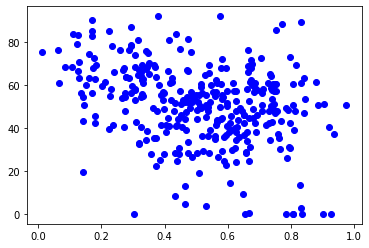

In [91]:
# scatter plot
x = temp2['SVI4']
y = temp2['COVID_VACC_RATE']

plt.plot(x, y, 'o', color='blue');

## Exercise 4: Remove outliers
Remove all rows from temp5 where 'COVID_VACC_RATE' column value is over 99 percentile and copy into a new dataframe X

In [92]:
percentile_threshold = np.percentile(temp2['COVID_VACC_RATE'], 99)
X = temp2[temp2['COVID_VACC_RATE'] < percentile_threshold]

In [93]:
[temp2.shape,X.shape]

[(331, 28), (327, 28)]

### Let us now see which features are more important in assessing COVID_VACC_RATES

## Exercise 5: Best feature selection
Use the pandas qcut() method to create a new column 'COVID_VACC_RATE_CLASSES' in X with q=[0, 0.2, 0.4, 0.6, 0.8, 1] ; we need to do break down COVDI_VACC_RATE into classes before we can use one of the best feature selection method.
Save 'COVID_VACC_RATE_CLASSES' column of X into y and 'COVID_VACC_RATE' into yp and then delete those column from X.

In [94]:
X.head()

y = pd.qcut(X['COVID_VACC_RATE'], q = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = False)
yp = X['COVID_VACC_RATE']
y

ZIP
85003    3
85004    4
85006    2
85007    3
85008    2
85009    1
85013    4
85014    3
85015    2
85016    3
85017    1
85018    4
85019    1
85020    3
85021    3
85022    2
85023    2
85024    3
85027    2
85028    4
85029    1
85031    1
85032    2
85033    2
85034    1
85035    1
85037    2
85040    2
85041    2
85042    3
85043    2
85044    4
85045    4
85048    4
85050    4
85051    1
85053    1
85054    4
85083    3
85085    4
85086    2
85087    1
85118    4
85119    2
85120    2
85122    2
85123    1
85128    1
85131    1
85132    1
85135    1
85137    0
85138    3
85139    2
85140    1
85141    0
85142    2
85143    1
85145    1
85172    3
85173    1
85192    0
85193    1
85194    2
85201    2
85202    2
85203    1
85204    1
85205    3
85206    4
85207    3
85208    2
85209    3
85210    1
85212    3
85213    2
85215    4
85224    3
85225    2
85226    4
85233    3
85234    2
85248    4
85249    4
85250    4
85251    3
85253    4
85254    4
85255    4
85257    3
85258 

In [95]:
y.describe()

count    327.000000
mean       2.000000
std        1.420706
min        0.000000
25%        1.000000
50%        2.000000
75%        3.000000
max        4.000000
Name: COVID_VACC_RATE, dtype: float64

Now we have our feature set X and targets y and yp for modeling. Before we attempt to do modeling let us try to limit to the best potential features to work with:
Exercise 6:

Scale the dataframe X using MinMaxScaler and call the result X_scaled
Turn it into a pandas dataframe and assign the same column values as X
Also scale yp and call the result yp_scaled

In [96]:
X_scaler = MinMaxScaler()
X_scaled_df = pd.DataFrame(X_scaler.fit_transform(X), columns = X.columns).drop(labels = ['COVID_VACC_RATE'], axis = 1)

yp_scaler = MinMaxScaler()
yp_scaled = yp_scaler.fit_transform(np.array(yp).reshape(-1, 1)).ravel().astype('float')

## Exercise 7:
Now run the sklearn.feature_selection method RFE as below on X_scaled_df with y as target and select the best features
Create a list top_cols of the best features.  We used 14 features last week, but that may or may not be a good choice.

In [97]:
from sklearn.feature_selection import RFE
from sklearn import svm

X_scaled_df_1 = X_scaled_df.drop(labels = ['Educ_Doctorate_prop','Single_w_roommate_Family_prop', 'Others_count_prop'], axis = 1)

svm_estimator = svm.SVC(kernel='linear') #initialize the SVM estimator

#TODO: Recursive Feature Elimination
rfe = RFE(estimator= svm_estimator, verbose=1, n_features_to_select= 25)

rfe.fit(X_scaled_df_1, y) #Note: this may take a few minutes to complete

#TODO: display the names of the selected features below
print(list(X_scaled_df_1.columns[rfe.get_support(indices=True)]))

top_cols = X_scaled_df_1.columns[rfe.get_support(indices=True)]

['SVI1', 'SVI2', 'SVI3', 'SVI4', 'SVI', 'Educ_<HS_prop', 'Educ_HS_prop', 'Educ_AA_prop', 'Educ_BA_prop', 'Educ_Msters_prop', 'Educ_Prof_prop', 'Husband_Wife_Family_prop', 'Single_Parent_Family_prop', 'Single_Family_prop', 'Whites_count_prop', 'AA_count_prop', 'AI_Alaskan_count_prop', 'Asian_count_prop', 'Hawaiian_PI_count_prop', 'Multi_count_prop', 'population', 'population_density', 'median_home_value', 'median_household_income']


### The folowing method is to check whether some columns are highly collinear.


In [98]:
# Import library for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [99]:
calc_vif(X_scaled_df_1)

,variables,VIF
0,SVI1,380.155103
1,SVI2,94.667772
2,SVI3,104.989331
3,SVI4,184.189174
4,SVI,1508.771805
5,Educ_<HS_prop,117.984039
6,Educ_HS_prop,302.236612
7,Educ_AA_prop,32.254278
8,Educ_BA_prop,110.224305
9,Educ_Msters_prop,32.694705


### Exercise 8: Remove high VIF columns
Remove those columns from X_top_df with VIF higher than 10 and copy the rest into X_final_df

In [100]:
X_final_df = X_scaled_df_1.drop(labels = ['SVI'], axis = 1)

## Now we are ready for modeling

### Exercise 9: Train test split
Split the data into train and test sets with 80:20 split

In [101]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_final_df, yp)

[[-42.77213613]]


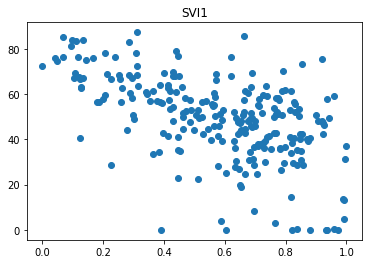

[[-40.2093108]]


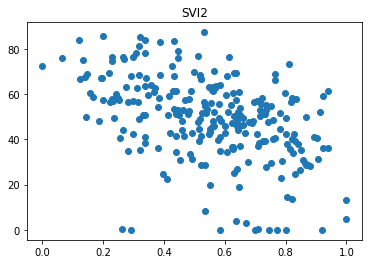

[[-15.11736512]]


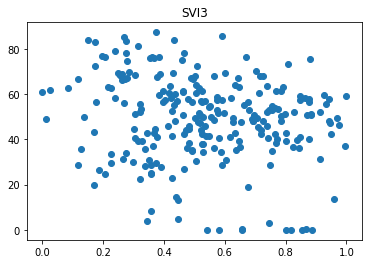

[[-32.15173496]]


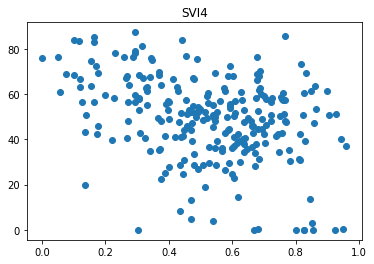

[[-42.20325787]]


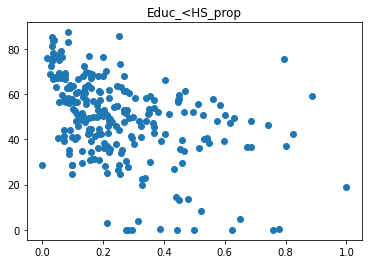

[[-46.85170755]]


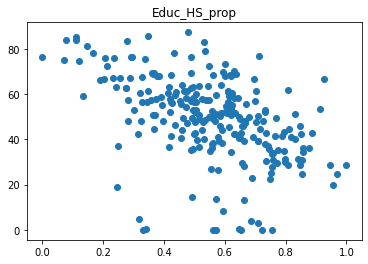

[[19.13368729]]


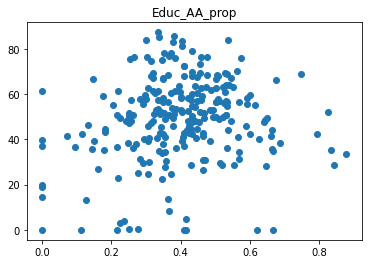

[[55.61825425]]


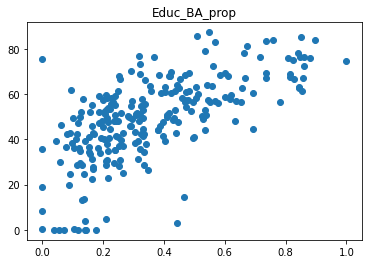

[[45.76712563]]


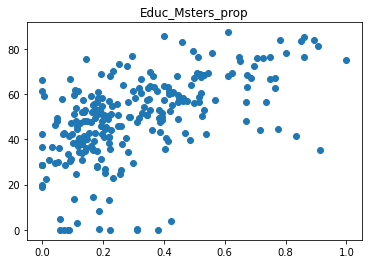

[[65.58664743]]


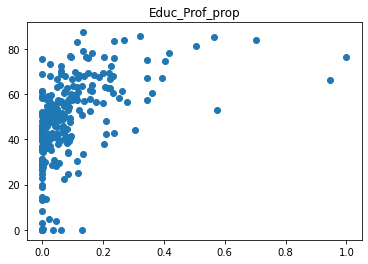

[[22.35674724]]


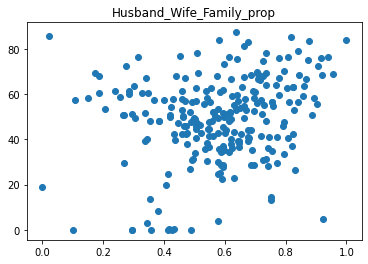

[[-41.98939796]]


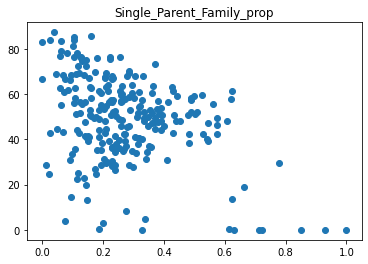

[[4.82853121]]


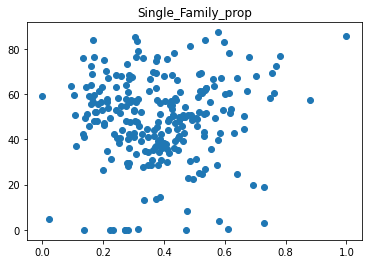

[[32.05653283]]


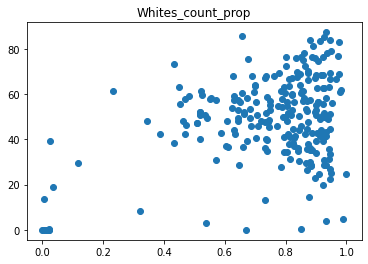

[[29.75955092]]


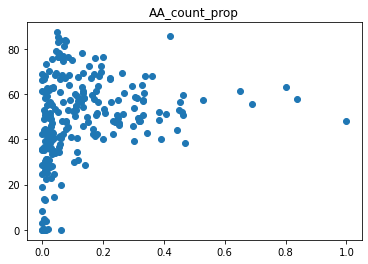

[[-42.83676131]]


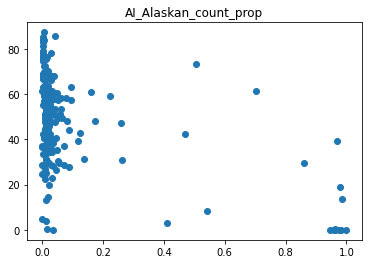

[[60.40353692]]


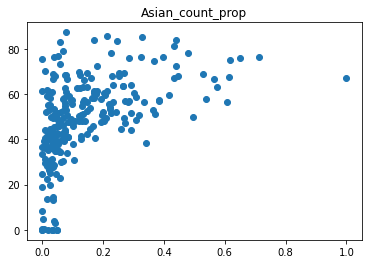

[[3.54863683]]


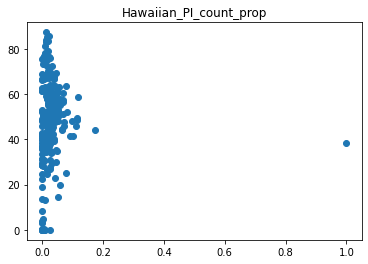

[[19.23441556]]


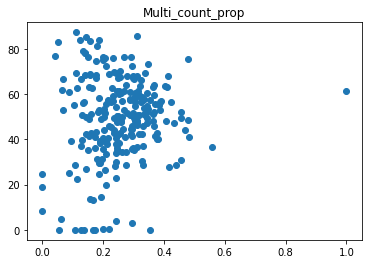

[[30.55020126]]


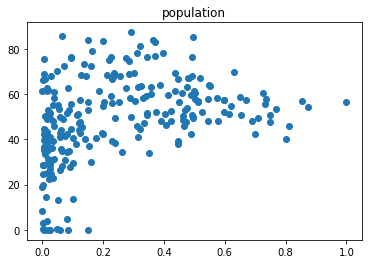

[[23.16706689]]


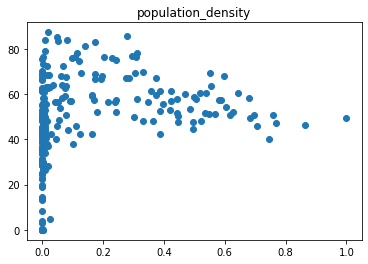

[[89.2134324]]


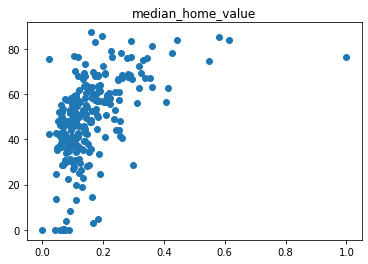

[[61.61912531]]


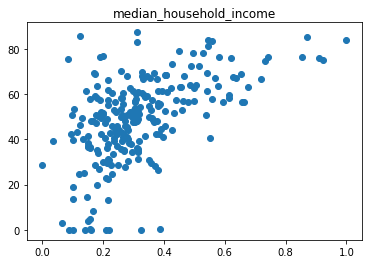

In [124]:
for column in X_train.columns:
    plt.title(column)
    plt.scatter(X_train[column], y_train)
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[column].to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1, 1))
    print(lin_reg.coef_)
    plt.show()

In [127]:
for column in X_train.columns:
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[column].to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1, 1))
    print(column)
    r2 = lin_reg.score(X_train[column].to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1, 1))
    print(r2)
    print(lin_reg.coef_)

SVI1
0.30775194617824075
[[-42.77213613]]
SVI2
0.20906224520429817
[[-40.2093108]]
SVI3
0.03331423923057353
[[-15.11736512]]
SVI4
0.13095909734622346
[[-32.15173496]]
Educ_<HS_prop
0.18041737631755972
[[-42.20325787]]
Educ_HS_prop
0.22860112651041117
[[-46.85170755]]
Educ_AA_prop
0.02548579346367486
[[19.13368729]]
Educ_BA_prop
0.42586364858531645
[[55.61825425]]
Educ_Msters_prop
0.2921125190864784
[[45.76712563]]
Educ_Prof_prop
0.22429953305888384
[[65.58664743]]
Husband_Wife_Family_prop
0.0485669569260908
[[22.35674724]]
Single_Parent_Family_prop
0.14170082118142024
[[-41.98939796]]
Single_Family_prop
0.0018012413899322066
[[4.82853121]]
Whites_count_prop
0.13665297652385466
[[32.05653283]]
AA_count_prop
0.061812031219925956
[[29.75955092]]
AI_Alaskan_count_prop
0.22758263027924808
[[-42.83676131]]
Asian_count_prop
0.2519444583553968
[[60.40353692]]
Hawaiian_PI_count_prop
0.00016234915796220495
[[3.54863683]]
Multi_count_prop
0.012638892707913185
[[19.23441556]]
population
0.14301525

In [129]:
for column in X_train.columns:
    lin_reg = LinearRegression()
    lin_reg.fit(X_train[column].to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1, 1))
    print(column)
    r2 = lin_reg.score(X_train[column].to_numpy().reshape(-1,1), y_train.to_numpy().reshape(-1, 1))
    print(r2)

SVI1
0.30775194617824075
SVI2
0.20906224520429817
SVI3
0.03331423923057353
SVI4
0.13095909734622346
Educ_<HS_prop
0.18041737631755972
Educ_HS_prop
0.22860112651041117
Educ_AA_prop
0.02548579346367486
Educ_BA_prop
0.42586364858531645
Educ_Msters_prop
0.2921125190864784
Educ_Prof_prop
0.22429953305888384
Husband_Wife_Family_prop
0.0485669569260908
Single_Parent_Family_prop
0.14170082118142024
Single_Family_prop
0.0018012413899322066
Whites_count_prop
0.13665297652385466
AA_count_prop
0.061812031219925956
AI_Alaskan_count_prop
0.22758263027924808
Asian_count_prop
0.2519444583553968
Hawaiian_PI_count_prop
0.00016234915796220495
Multi_count_prop
0.012638892707913185
population
0.14301525271954907
population_density
0.07157694953774685
median_home_value
0.265853935887554
median_household_income
0.2981811802411469


Columns with highest magnitude of slope:
1. median_home_value +
2. Educ_Prof_prop +
3. median_household_income + 
4. Asian_count_prop +
5. Educ_BA_prop +
6. Educ_HS_prop -
7. AI_Alaskan_count_prop
8. SVI1 -
9. Educ_< HS_prop -
10. Single_Parent_Family_prop -

top 10 r^2 values:
1. Educ_BA_prop
2. SVI1
3. median_household_income
4. Educ_Msters_prop
5. median_home_value
6. Asian_count_prop
7. Educ_HS_prop
8. AI_Alaskan_count_prop
9. Educ_Prof_prop
10. SVI2

In [103]:
X_train.head()

,SVI1,SVI2,SVI3,SVI4,Educ_<HS_prop,Educ_HS_prop,Educ_AA_prop,Educ_BA_prop,Educ_Msters_prop,Educ_Prof_prop,Husband_Wife_Family_prop,Single_Parent_Family_prop,Single_Family_prop,Whites_count_prop,AA_count_prop,AI_Alaskan_count_prop,Asian_count_prop,Hawaiian_PI_count_prop,Multi_count_prop,population,population_density,median_home_value,median_household_income
117,0.879924,0.766138,0.741879,0.324549,0.542652,0.456776,0.308380,0.221031,0.122205,0.000000,0.679029,0.317587,0.257213,0.702456,0.116051,0.006831,0.010756,0.000000,0.218085,0.009497,0.000230,0.080809,0.207749
119,0.691893,0.492900,0.266055,0.683119,0.164808,0.799335,0.283487,0.315942,0.192651,0.000000,0.494618,0.204406,0.505429,0.944364,0.011760,0.012816,0.033632,0.000000,0.181843,0.038003,0.001149,0.120607,0.216006
151,0.827398,0.695123,0.876742,0.722732,0.445204,0.499605,0.350021,0.232462,0.180498,0.058367,0.552266,0.413326,0.309567,0.651627,0.126866,0.019121,0.133254,0.030349,0.386113,1.000000,0.218276,0.110001,0.239322
315,0.648237,0.640431,0.465169,0.491583,0.434160,0.555192,0.161237,0.166478,0.207659,0.000000,0.485083,0.175126,0.534949,0.944776,0.016130,0.010255,0.026910,0.026788,0.144202,0.027557,0.002184,0.101718,0.186457
142,0.919725,0.269181,0.879402,0.490079,0.794643,0.339046,0.252918,0.000000,0.144771,0.000000,0.640809,0.224324,0.409891,0.676656,0.031551,0.013372,0.000000,0.000000,0.480260,0.005610,0.000805,0.023132,0.084130


In [104]:
print("Training set dim:{}, Test set dim:{}".format(X_train.shape, X_test.shape))

Training set dim:(245, 23), Test set dim:(82, 23)


## Linear Regression, Ridge, and Lasso


In [105]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression

### Exercise 10: Fit and predict with Linear Regression, create a scatter plot
Fit the LinearRegression model on the X_train
Predict on X_test
Create a scatter plot between predicted 'COVID_VACC_RATE' and actual ones (y_test) on the test. You may want to scale them back to original values to make better sense of those numbers.
How will you assess whether the predictions are any good? Develop a measure.

Error:  13.226183647267375


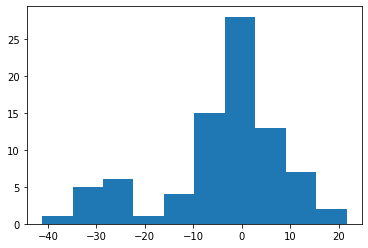

In [106]:
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression().fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
plt.hist(y_pred - y_test)

print('Error: ', mean_squared_error(y_test, y_pred, squared=False))

## Now try regularization: Ridge in this case

### Exercise 11: Fit and predict with Ridge, create a scatter plot
Repeat the same as in exercise 10 but this time with Ridge instead of LinearRegression
Try with different values alpha, the regularization parameter and see wich one gives us best favorable error rate

Error:  13.096876882879808


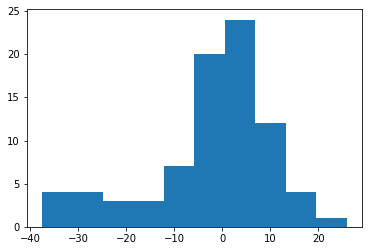

In [107]:
ridge = Ridge().fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)
plt.hist(y_pred_ridge - y_test)

print('Error: ', mean_squared_error(y_test, y_pred_ridge, squared=False))

## Now neural networks

### Exercise 12: Fit and predict with MLP using Keras, create a scatter plot
Repeat the same as in exercise 10 but this time with a basic MLP implemented using tensorflow.keras package instead of LinearRegression
Try with different number of hidden layers, activations, optimizers and see wich one gives us best favorable error rate

In [117]:
model = Sequential()

layers = [X_train.shape[1], 160, 80, 40, 1]
for i in range(0, len(layers) - 1):
  model.add(Dense(layers[i + 1], activation='relu', input_shape=(layers[i],)))

model.compile(optimizer = 'Adam', loss = 'mean_squared_error')

result = model.fit(X_train, y_train, validation_split = 0.1, epochs = 100, batch_size = 1)

Epoch 1/100
220/220 [==============================] - 1s 2ms/step - loss: 764.3022 - val_loss: 283.4330
Epoch 2/100
220/220 [==============================] - 0s 2ms/step - loss: 184.6732 - val_loss: 200.8018
Epoch 3/100
220/220 [==============================] - 0s 1ms/step - loss: 171.3036 - val_loss: 186.2815
Epoch 4/100
220/220 [==============================] - 0s 2ms/step - loss: 158.8651 - val_loss: 185.8574
Epoch 5/100
220/220 [==============================] - 0s 1ms/step - loss: 159.2111 - val_loss: 181.3345
Epoch 6/100
220/220 [==============================] - 0s 1ms/step - loss: 157.0357 - val_loss: 185.9876
Epoch 7/100
220/220 [==============================] - 0s 1ms/step - loss: 157.6967 - val_loss: 173.9010
Epoch 8/100
220/220 [==============================] - 0s 1ms/step - loss: 156.1410 - val_loss: 175.8355
Epoch 9/100
220/220 [==============================] - 0s 1ms/step - loss: 153.4819 - val_loss: 296.7979
Epoch 10/100
220/220 [==============================] -

In [118]:
import sklearn
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
sklearn.metrics.mean_squared_error(y_test, y_pred, squared=False)

14.430167173622365

In [121]:
results = pd.DataFrame(index = X_test.index)
results['prediction'] = y_pred
results['COVID_VAX_RATE'] = y_test.to_numpy()

results

,prediction,COVID_VAX_RATE
210,63.002026,85.27
77,56.523670,60.99
8,47.467976,48.40
215,68.502632,71.88
285,39.476704,33.00
282,41.947166,44.07
284,29.773750,57.48
162,49.900368,54.62
224,61.864422,64.16
160,64.959305,67.94


### Important Question:

Last week's data was census tract data.  Census tracts are well defined spatially, and very roughly uniform in population - they vary from about 2500 people per tract to about 8000 people per tract.  That sounds like a pretty wide spread, but it isn't really, at least compared with zip codes.
    
 Ordinarilly, data is often reported according to zip code.  These may be convenient because people know their own zip code.  However populations in each zip code are non-constant, and in fact flucate over time.
 
 It's possible that small population zip codes skew the data - for this week's data set, the statistics for a zip code of size 41 people carries as much weight as one with 75,000.  It might be interesting to recompute the statistics for different subsets of the state.  One natural grouping would be on zip code population size.  Another would be to group them according to population density.  A third is to do a comparison between two cities in AZ, say Tempe and Phoenix.